参考链接
http://nlp.seas.harvard.edu/2018/04/03/attention.html </br>
视频说明:
https://www.bilibili.com/video/BV1pQ4y1z7Uf

# transformer 实现英中翻译

In [2]:
import torch
import jieba
import seaborn
import numpy as np
import torch.nn as nn
import math, copy, time
import torch.nn.functional as F

from tqdm import tqdm
from torchtext import data
from torch.nn import LayerNorm
import matplotlib.pyplot as plt
from torchtext.legacy.data import Field
from torch.autograd import Variable
from nltk.translate.bleu_score import sentence_bleu

seaborn.set_context(context="talk")
%matplotlib inline

In [3]:
class Config:
    def __init__(self):
        self.data_path = "./data"
        self.testing_path = self.data_path + '/testing.txt'
        self.training_path = self.data_path + '/training.txt'
        self.validation_path = self.data_path + '/validation.txt'
        self.init_token = '<bos>'#开始符号
        self.eos_token = '<eos>'#终止符号
        self.fix_length = 50
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #放到GPU上
        self.batch_size = 128
        #批次大小
        self.beam_size = 4
        self.n_layers = 6
        self.h = 8
        self.d_model = 512
        self.d_ff = 2048
        self.dropout = 0.1
        self.epochs = 20
        self.load_model = False               
        self.load_model_path = 'weight.ckpt'     
        self.smoothing = 0
        self.factor = 2
        self.warmup = 40
        self.load_path = '../input/transformer-translate-entoch/transformer.pth'


<img src='http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png'>

## embedding 

In [4]:
class Embeddings(nn.Module):
    """
    d_model:512,Embeddings_size
    """
    def __init__(self, d_model,  vocab_size):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)#做了*开方的效果

## 位置编码

$$
PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}}  \quad) \\
PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}}  \quad)
$$

$pos$表示是第几个词,$2i$和$2i+1$ 表示的是这个词第$2i$和$2i+1$个维度 
维度是偶数用第一个公式，维度是奇数用第二个公式

(1, 100, 512)


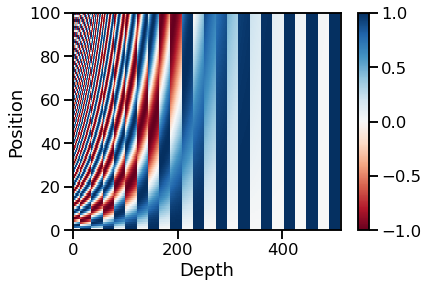

In [5]:
#https://tensorflow.google.cn/tutorials/text/transformer
import matplotlib.pyplot as plt
import tensorflow as tf

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # 将 sin 应用于数组中的偶数索引（indices）；2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # 将 cos 应用于数组中的奇数索引；2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)




pos_encoding = positional_encoding(100, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

但是会出现数值过大的问题，
所以说我们用指数取代

In [6]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):#d_model的默认值是512，每个词是512维
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)#dropout的几率
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)#max_len*d_model维度的0矩阵
        position = torch.arange(0, max_len).unsqueeze(1)#0,max_len-1的值按照维度1展开，（0是行，1是列）
        #因为刚才的0矩阵的维度要匹配上位置
        div_term = torch.exp(torch.arange(0, d_model, 2) *#0到d_model中，每隔2个的数值，如0,2,4,6,8...
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)#维度跳跃，从0开始间隔为2
        pe[:, 1::2] = torch.cos(position * div_term)#维度跳跃，从1开始间隔为2
        pe = pe.unsqueeze(0)#解压到0维度
        self.register_buffer('pe', pe)#加载到内存中，方便读取
        
    def forward(self, x):#前向传播
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

https://tensorflow.google.cn/tutorials/text/transformer
<img src='https://tensorflow.google.cn/tutorials/text/transformer_files/output_1kLCla68EloE_1.png'>

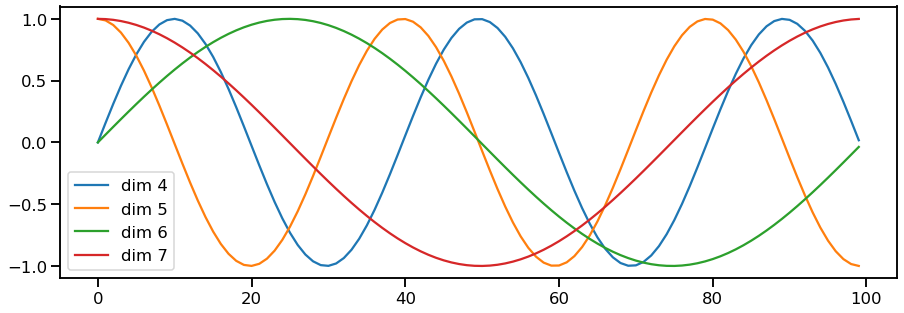

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20,0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## selfAttention 

<img src="https://gitee.com/xu_kai_xuyouqian/picture-bed/raw/master/20211013122948.png"/>
<img src="https://gitee.com/xu_kai_xuyouqian/picture-bed/raw/master/20211013123436.png"/>

In [ ]:
#注意力机制
def attention(query, key, value, mask=None, dropout=None):
    #q,k,v，
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    # batch size, head size, query len , head dim
    # batch size, head size, key len , head dim
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:#掩码，这里是softmax指数
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h#几个头
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        #深复制4份
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """
        key len = value len
        query = [batch size, query len, d_model]
        key = [batch size, key len, d_model]
        value = [batch size, value len, d_model]
        mask = [batch size,1, key len] or [batch size, query len, key len]
        """
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)#view与reshape类似
             for l, x in zip(self.linears, (query, key, value))]#这里是计算x与W_Q,W_K,W_V三个的产出QKV
        
        # 2) Apply attention on all the projected vectors in batch. 
        # x = batch size, h, query len, h_dim
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)#ffn

## encoder

### layernormal

In [ ]:
# layer normal 演示
import torch
from torch import nn
output = torch.range(1, 24, dtype=torch.float32).contiguous().view(2, 3, 4)
output[0][0][0] = 2
output[-1][-1][-1] = 30
print('*' * 20 + '原始数据' + '*' * 20)
print(output)
print('*' * 20 + 'layernormal结果' + '*' * 20)
layernormal = nn.LayerNorm(4)(output)
print(layernormal)
mean = torch.mean(output, dim=2).unsqueeze(2)
std = torch.std(output, dim=2).unsqueeze(2)
print('*' * 20 + '手动layernormal结果' + '*' * 20)
print((output - mean) / std * (2 / 3 ** (0.5)))
'''

********************原始数据********************
tensor([[[ 2.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]],

        [[13., 14., 15., 16.],
         [17., 18., 19., 20.],
         [21., 22., 23., 30.]]])
********************layernormal结果********************
tensor([[[-0.9045, -0.9045,  0.3015,  1.5075],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]],

        [[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-0.8485, -0.5657, -0.2828,  1.6971]]],
       grad_fn=<NativeLayerNormBackward>)
********************手动layernormal结果********************
tensor([[[-0.9045, -0.9045,  0.3015,  1.5076],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]],

        [[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-0.8485, -0.5657, -0.2828,  1.6971]]])


'''
None

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.

    add&norm
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## decoder

### decoder mask

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    #下三角矩阵
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    #上三角矩阵，且往上移动一下
    """
        [
        [0(k=0),0(k=1),1]
        [0,0(k=0),0(k=1)]
        [0,0,0(k=0)]
        ]
    """
    return torch.from_numpy(subsequent_mask) == 0
print(subsequent_mask(4))
"""
tensor([[[ True, False, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True,  True]]])
"""
None

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        x: decoder input
        memory: encoder output
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

## 全连接

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## 完整模型

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

## 创建模型

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

## batch

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        """
        src = batch size, seq len
        
        """
        self.src = src
        # src_mask = batch size, 1, seq len
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## warm up

In [ ]:
#warmup
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def zero_grad(self):
        self.optimizer.zero_grad()
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## 标签平滑

In [ ]:
#文本翻译更看重这个
#kl散度
""" python
预测softmax_res = [0.1, 0.3, 0.6]
真实结果是[2] -->[0,0,1]
如果不做平滑直接是这两者计算交叉信息熵
如果做了平滑可以把真实结果修改为
[0.1,0.1,0.8]
计算他们的kl散度"""


In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    """
    size:预测词典长度
    smoothing:分给真实标签，1-smoothing，其余的smoothing/(n-1)
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## 计算损失

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        """
        norm 非pad的单词个数
        """
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

## 训练单个epoch

In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 模拟训练

In [ ]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    """
    V : 词汇表长度
    nbatches : 有多少个batch
    batch：batch size
    """
    for i in range(nbatches):
        # 10 是句子长度
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [ ]:
V = 11  # vocabulary size
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

## 贪心解码

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    batch_size, _ = src.shape
    ys = torch.ones(batch_size, 1).fill_(start_symbol).type_as(src.data)

    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        
        # prob = batch size, vocab size
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = -1)
        
        ys = torch.cat([ys, next_word.unsqueeze(1)], dim=-1)
    return ys

src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10],
                                 [1,2,3,4,8,6,7,8,9,10]
                                ]) )
src_mask = Variable(torch.ones(2, 1, 10) )
print(src_mask)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1)[0])

## beam search 解码

In [ ]:
class Hypothesis:
    """
    保存beamsearch 的备选方案
    """

    def __init__(self, tokens, log_probs):
        self.tokens = tokens  # list of all the tokens from time 0 to the current time step t
        self.log_probs = log_probs  # list of the log probabilities of the tokens of the tokens

    def extend(self, token, log_prob):
        """
        Method to extend the current hypothesis by adding the next decoded token and all the informations associated with it
        """
        return Hypothesis(tokens=torch.cat([self.tokens, token]),  # we add the decoded token
                          log_probs=self.log_probs + [log_prob],  # we add the log prob of the decoded token
                          )

    @property
    def latest_token(self):
        return self.tokens[-1]

    @property
    def tot_log_prob(self):
        return sum(self.log_probs)

    @property
    def avg_log_prob(self):
        return self.tot_log_prob / len(self.tokens)

def get_top_k_beam(prediction, k):
    top_k_probs, top_k_ids = nn.functional.softmax(prediction, 0).topk(k)

    top_k_log_probs = torch.log(top_k_probs)
    return top_k_log_probs, top_k_ids

In [ ]:
def beam_search(model, src, src_mask, max_len, start_symbol, beam_size, device):
    # memory = batch size, src len, d_model
    memory = model.encode(src, src_mask)
    batch_size, _ = src.shape
    all_tokens = []
    for batch in tqdm(range(batch_size)):
        batch_memory = memory[batch]
        batch_src_mask = src_mask[batch]

        tokens = beam_search_single_batch(model, batch_memory, batch_src_mask,
                                                  beam_size, start_symbol, max_len, device)
        
        all_tokens.append(tokens)
    all_tokens = torch.stack(all_tokens)
    return all_tokens

In [ ]:
def beam_search_single_batch(model, memory, src_mask, beam_size, start_symbol, max_len, device):
    """
    memory = [src len, d_model]
    """
    # memory = [beam size, src len, d_model]
    memory = memory.unsqueeze(0).repeat(beam_size, 1, 1)
    hys = [Hypothesis(torch.LongTensor([start_symbol]).to(device), [0]) for _ in range(beam_size)]
    
    for i in range(max_len-1):
        # beam_input = [beam size, decoded len]
        beam_input = torch.stack([h.tokens for h in hys])
        trg_mask= subsequent_mask(beam_input.size(1)).type_as(memory.data)
        
        out = model.decode(memory, src_mask, beam_input, trg_mask)
        probs = model.generator(out[:,-1])  # beam size, vocab size
        
        # 把之前的最优解再扩展一个词，先要获取之前最优解的个数
        num_ori_hyps = 1 if i == 0 else len(hys)
 
        # 创建列表保存新的结果
        all_hyps = []
        
        # 遍历添加所有可能结果
        for j in range(num_ori_hyps):
            prob = probs[j, :]
            top_k_log_probs, top_k_ids = get_top_k_beam(prob, beam_size)
            
            for log_prob, top_k_id in zip(top_k_log_probs, top_k_ids):
                top_k_id = top_k_id.view(-1)
                new_hys = hys[j].extend(top_k_id, log_prob)
                all_hyps.append(new_hys)
        
        
        # 重置
        hys = []
        # 按照概率来排序
        sorted_hyps = sorted(all_hyps, key = lambda h:h.avg_log_prob, reverse=True)
        hys = sorted_hyps[:beam_size]
    
    tokens = hys[0].tokens
    return tokens
        

## 数据准备

In [ ]:
class MyDataset(data.Dataset):

    def __init__(self, datatuple, text_field, label_field, test=False):  # datatuple指的是元组('this moive is great',1)
        fields = [("text", text_field), ("label", label_field)]
        lists = []
        for content, label in tqdm(datatuple):
            # Example: Defines a single training or test example.Stores each column of the example as an attribute.
            lists.append(data.Example.fromlist([content, label], fields))
        # 之前是一些预处理操作，此处调用super初始化父类，构造自定义的Dataset类
        super().__init__(lists, fields)


def read_data(path):
    data_list = []
    with open(path,encoding="utf-8") as F:
        for line in F:
            line = line.split("\t")
            text = line[0]
            label = line[-1].strip().replace(' ','')
            data_list.append((text,label))
        return data_list
           


    
def prepare_data_iter(config):
    train_data_lists = read_data(config.training_path)
    test_data_list = read_data(config.testing_path)
    validation_data_list = read_data(config.validation_path)
    
    SRC = Field(tokenize=lambda x: x.split(), init_token=config.init_token, eos_token=config.eos_token,
                fix_length=config.fix_length)
    
    SRC = Field(tokenize=lambda x: x.split(), 
                fix_length=config.fix_length)

    LABEL = Field(tokenize=jieba.lcut, init_token=config.init_token, eos_token=config.eos_token,
                  fix_length=config.fix_length)

    train_dataset = MyDataset(train_data_lists, SRC, LABEL)
    test_dataset = MyDataset(test_data_list, SRC, LABEL)
    valid_dataset = MyDataset(validation_data_list,SRC,LABEL)

#     SRC.build_vocab(train_dataset,min_freq = 2)  # '<unk>':0,'<sos>':1,'i':2
#     LABEL.build_vocab(train_dataset,min_freq = 2)
    SRC.build_vocab(train_dataset)  
    LABEL.build_vocab(train_dataset)
    
    train_iter = data.BucketIterator(dataset=train_dataset, batch_size=config.batch_size,
                                     shuffle=True, sort_key=lambda x: len(x.text),
                                      sort_within_batch=False, repeat=False, device = config.device)

    test_iter = data.BucketIterator(dataset=test_dataset, batch_size=config.batch_size,
                                     shuffle=False, sort_key=lambda x: len(x.text),
                                      sort_within_batch=False, repeat=False, device = config.device)
    valid_iter = data.BucketIterator(dataset=valid_dataset, batch_size=config.batch_size,
                                     shuffle=False, sort_key=lambda x: len(x.text),
                                      sort_within_batch=False, repeat=False, device = config.device)
    return train_iter, test_iter, valid_iter, SRC, LABEL

## 数字转文字

In [ ]:
def tokens2sentence(preds, LABEL):
    sentences = []
    for tokens in preds:
        sentence = []
        for token in tokens:
            word = LABEL.vocab.itos[int(token.item())]
            
            if word == '<eos>':
                break
            sentence.append(word)
        sentences.append(sentence)

    return sentences

## 计算bleu score

https://blog.csdn.net/guolindonggld/article/details/56966200

In [ ]:
def computebleu(sentences, targets):
    score = 0
    count = len(sentences)
    assert (len(sentences) == len(targets))

    def cut_token(sentence):
        tmp = []
        for token in sentence:
            if token == "<eos>":
                break
            if token == '<unk>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
                tmp.append(token)
            else:
                tmp += [word for word in token]
        return tmp

    for sentence, target in zip(sentences, targets):
        sentence = cut_token(sentence)
        target = cut_token(target)
        score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))

    return score, count

## 训练和测试

In [ ]:
def run_epoch(data_iter, model, loss_compute, pad):
    """
    loss_compute：一个函数，包含全连接,计算损失，反向传播
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, ((src,trg),_) in enumerate(data_iter):
        src = src.permute(1,0)
        trg = trg.permute(1,0)
        batch = Batch(src, trg, pad)
        
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
            
    return total_loss / total_tokens

In [ ]:
def train_process(config, SRC, LABEL):

    pad = SRC.vocab.stoi['<pad>']
    src_vocab = len(SRC.vocab)
    tgt_vocab = len(LABEL.vocab)

    N = config.n_layers
    d_model = config.d_model
    d_ff = config.d_ff

    h = config.h
    dropout = config.dropout
    device = config.device
    model = make_model(src_vocab, tgt_vocab, N, d_model, d_ff, h, dropout).to(device)
    
    max_len = config.fix_length
    start_symbol = LABEL.vocab.stoi['<bos>']
    beam_size = config.beam_size
    

    # 损失函数
    smoothing = config.smoothing
    criterion = LabelSmoothing(tgt_vocab, pad, smoothing)

    # 优化器
    factor = config.factor
    warmup = config.warmup
    optimizer = torch.optim.Adam(model.parameters(),lr=0, betas = (0.9, 0.98), eps=1e-9)
    model_opt = NoamOpt(d_model, factor, warmup, optimizer)

    best_score = 0
    # 封装计算损失函数的对象
    loss_compute = SimpleLossCompute(model.generator, criterion, model_opt)
    for i in range(config.epochs):
        
        run_epoch(train_iter, model, loss_compute, pad)
        total_score, total_num, _ = test(model, valid_iter, pad, max_len, start_symbol,device, beam_size)
        
        print('epoch{}:total bleu score:{:.4f}, total scentence:{},average score{:.4f}'.format(
            i,total_score,total_num,total_score/total_num))
        if total_score/total_num > best_score:
            best_score = total_score/total_num
            # 保存模型
            torch.save(model.state_dict(),'transformer.pth')
    return model

In [ ]:
def test(model, data_iter, pad, max_len, start_symbol, device, beam_size = 1):
    model = model
    total_score = 0
    total_count = 0
    results = []
    print('testing...')
    for (src, trg), _ in tqdm(data_iter):
        
        src = src.permute(1,0)
        trg = trg.permute(1,0)
        src_mask = (src != pad).unsqueeze(-2)
        
        if beam_size == 1:
            ids = greedy_decode(model, src, src_mask, max_len, start_symbol)
            sentences = tokens2sentence(ids, LABEL)
            # label_text = tokens2sentence(ids, LABEL)
        else:
            ids = beam_search(model, src, src_mask, max_len, start_symbol, beam_size, device)
            sentences = tokens2sentence(ids, LABEL)
            
        targets = tokens2sentence(trg, LABEL)
        source = tokens2sentence(src, SRC)
#         results.append((source,targets,sentences))
        score, count = computebleu(sentences, targets)
        for src, tgt, pred in zip(source, targets,sentences):
            results.append((list(filter(lambda x: x!= '<pad>', src)), tgt, pred ))
        total_score += score
        total_count += count
    return total_score, total_count, results
                


In [ ]:
def load_model(config, LABEL, SRC):
    pad = SRC.vocab.stoi['<pad>']
    src_vocab = len(SRC.vocab)
    tgt_vocab = len(LABEL.vocab)

    N = config.n_layers
    d_model = config.d_model
    d_ff = config.d_ff

    h = config.h
    dropout = config.dropout
    device = config.device
    model = make_model(src_vocab, tgt_vocab, N, d_model, d_ff, h, dropout).to(device)
    model.load_state_dict(torch.load(config.load_path))
    return model

## main

In [ ]:
config = Config()
config.beam_size = 1
train_iter, test_iter, valid_iter, SRC, LABEL = prepare_data_iter(config)

In [ ]:
# 训练
model = train_process(config, SRC, LABEL)

In [ ]:
config.load_path = '../input/epoch-20-smooth-02/transformer.pth'
config.load_path = 'transformer.pth'
# config = Config()
# # 加载训练好的模型做预测
model = load_model(config, LABEL, SRC)
config.beam_size = 3
    
pad = SRC.vocab.stoi['<pad>']
max_len = config.fix_length
start_symbol = LABEL.vocab.stoi['<bos>']
beam_size = config.beam_size
device = config.device
total_score, total_scentence, res = test(model, test_iter, pad, max_len, start_symbol, device, beam_size )

In [ ]:
'''
0.2
(791.7836494832305, 2636)
0.1
(798.8936338983596, 2636)
0
(769.3034688196138, 2636)
'''

In [ ]:
total_score, total_scentence

In [ ]:
from IPython.display import FileLink
FileLink(r'./transformer.pth')

In [ ]:
for source, target, pred in res:
    print('-'*30)
    print('原文：',' '.join(source))
    print('预测：',''.join(pred))
    print('目标：',''.join(target))

---

warmup 展示
```pyhton
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import optim
from torch import nn
from matplotlib import pyplot as plt


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# 设置随机数种子
setup_seed(20)


class TensorDataset(Dataset):
    """Dataset wrapping data and target tensors.

    Each sample will be retrieved by indexing both tensors along the first
    dimension.

    Arguments:
        data_tensor (Tensor): contains sample data.
        target_tensor (Tensor): contains sample targets (labels).
    可以重写改成适合的方式
    """

    def __init__(self, data_tensor, target_tensor):
        assert data_tensor.size(0) == target_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)


class NoamOpt:
    "Optim wrapper that implements rate."

    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def rate(self, step=None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
               (self.model_size ** (-0.5) *
                min(step ** (-0.5), step * self.warmup ** (-1.5)))


class Model(nn.Module):
    def __init__(self, in_size, out_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(in_size, out_size)

    def forward(self, x):
        out = self.fc(x)
        return out


def train(model, data_iter, optimizer, loss_function):
    model.train()
    for x, y in data_iter:
        out = model(x)
        optimizer.zero_grad()
        loss = loss_function(out, y)
        loss.backward()
        optimizer.step()


    return model, optimizer


def test(model, data_iter):
    total_num = 0
    acc_num = 0
    model.eval()
    for x, y in data_iter:
        out = model(x)
        _, pred = torch.max(out, dim=-1)
        total_num += x.shape[0]
        acc_num += sum(pred == y)
    print('acc', acc_num / total_num)
    return model, optimizer


if __name__ == '__main__':

    opts = [NoamOpt(10, 1, 20, None),
            NoamOpt(10, 1, 40, None),
            NoamOpt(20, 1, 20, None)]
    plt.plot(np.arange(1, 100), [[opt.rate(i) for opt in opts] for i in range(1, 100)])
    plt.legend(["10:20", "10:40", "20:20"])
    None

    plt.show()

    # 构造训练集
    d = 10  # 特征维度
    n = 50  # 数据量

    X = torch.randn(n, d)  # shape = 50,10
    true_w = torch.randn(d, 1)
    Y = X @ true_w + torch.randn(n, 1) * 0.1
    Y[Y >= 0] = 1
    Y[Y < 0] = 0

    Y = Y.squeeze().long()
    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset=dataset, batch_size=8, shuffle=True, num_workers=2, )

    model = Model(10, 2)
    optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
    warm_up = NoamOpt(10, 2, 16, optimizer)
    # warm_up = optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.98), eps=1e-9)
    loss_function = nn.CrossEntropyLoss()

    for i in range(50):
        model, warm_up = train(model, loader, warm_up, loss_function)
        test(model, loader)
```

标签平滑展示
```python
from torch import nn
import torch
from torch.autograd import Variable


class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, smoothing=0.0, padding_idx=None):
        '''
        :param size: 标签种类
        :param padding_idx: 忽略某个标签
        :param smoothing: 0-1   0 表示不进行标签平滑 1 表示完全平滑
        '''
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        # 把平滑的可能性平均分给除了pad 和 真实的标签
        if self.padding_idx is not None:
            true_dist.fill_(self.smoothing / (self.size - 2))
        else:
            true_dist.fill_(self.smoothing / (self.size - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                '''
                把真实标签为padding_idx的标签的所有都调成0,这样pad就不会影响损失
                最开始是
                [2, 1, 0]变为
                本来是tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
                [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
                [0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
                ---->
                tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
                [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
                [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
                '''
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])

label = Variable(torch.LongTensor([2, 1, 0]))

crit = LabelSmoothing(5, 0.4, 0)

print(crit(predict, label))
# 验证第三条数据对损失没有任何贡献
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0, 0, 0, 0]])

print(crit(predict, label))

# 让pad 影响损失
crit = LabelSmoothing(5, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
print(crit(predict, label))

torch.LongTensor

```